<a href="https://colab.research.google.com/github/honekiti/honekiti.github.io/blob/main/SIGNATEcup_program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#今の所(2024/08/12)流れ

tutorialのコードをベース

不均衡データなので、アンダーサンプリング・バギングを実装する

モデルを変える

#8/30
モデルをスタッキングで行う

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.base import clone

In [ ]:
# データの読み込み
train = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/test.csv")


In [ ]:
# age列を取り出す
age = train['Age']

# 漢数字を数値に変換する関数
def kanji_to_int(kanji):
    kanji_num_dict = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
                      '百': 100, '千': 1000, '万': 10000, '億': 100000000}

    num = 0
    temp = 0
    for char in kanji:
        if char in kanji_num_dict:
            if kanji_num_dict[char] >= 10:
                if temp == 0:
                    temp = 1
                num += temp * kanji_num_dict[char]
                temp = 0
            else:
                temp += kanji_num_dict[char]
        else:
            return None

    num += temp
    return num

# age列の前処理を行う関数
def preprocess_age_data(data):
    processed_data = []

    for item in data:
        if pd.isnull(item):
            processed_data.append(np.nan)
            continue

        # 全角数字を半角に変換
        item = str(item).translate(str.maketrans('０１２３４５６７８９', '0123456789'))

        # 漢数字を数値に変換
        item = re.sub(r'[一二三四五六七八九十百千万億]+', lambda x: str(kanji_to_int(x.group())), item)

        # 「歳」や「才」などの文字を削除
        item = re.sub(r'[歳才]', '', item)

        # 数値変換が可能かどうかを確認して変換
        try:
            processed_data.append(int(item))
        except ValueError:
            processed_data.append(np.nan)

    return processed_data

# ageデータの前処理を実行
train['age'] = preprocess_age_data(age)
test['age'] = preprocess_age_data(age)

# 前処理されたデータを表示
print(train[['Age', 'age']])


       Age   age
0      50歳  50.0
1      56歳  56.0
2      NaN   NaN
3     三十七歳  37.0
4      48歳  48.0
...    ...   ...
3484   40歳  40.0
3485   40代   NaN
3486   31歳  31.0
3487   56歳  56.0
3488   42歳  42.0

[3489 rows x 2 columns]


In [ ]:
# Gender列を取り出す
gender_data = train['Gender']

# 前処理関数
def preprocess_gender_data(data):
    processed_data = []

    for item in data:
        # nullデータをチェック
        if pd.isnull(item):
            processed_data.append(item)
            continue

        # 全角英字を半角に変換
        item = item.translate(str.maketrans('ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ',
                                            'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'))

        # 小文字に変換
        item = item.lower()

        # スペースや全角スペースを削除
        item = re.sub(r'\s+', '', item)

        # 変換されたデータをリストに追加
        processed_data.append(item)

    return processed_data

# Genderデータの前処理を実行
train['gender'] = preprocess_gender_data(gender_data)
test['gender'] = preprocess_gender_data(gender_data)

# 前処理されたデータを表示
print(train[['Gender', 'gender']])

      Gender  gender
0       male    male
1       Male    male
2     Female  female
3     female  female
4     female  female
...      ...     ...
3484    Male    male
3485    Male    male
3486  FEMALE  female
3487    Male    male
3488    male    male

[3489 rows x 2 columns]


In [ ]:
# DurationOfPitch列を取り出す
duration_data = train['DurationOfPitch']

# 前処理関数
def preprocess_duration_data(data):
    processed_data = []

    for item in data:
        # nullデータをチェック
        if pd.isnull(item):
            processed_data.append(np.nan)
            continue

        # 秒を分に変換
        if '秒' in item:
            # 数値部分を抽出して秒を分に変換
            seconds = int(re.findall(r'\d+', item)[0])
            minutes = seconds / 60
            processed_data.append(minutes)
        elif '分' in item:
            # 数値部分を抽出してそのまま分として使用
            minutes = int(re.findall(r'\d+', item)[0])
            processed_data.append(minutes)
        else:
            # 想定外の形式の場合、NaNを追加
            processed_data.append(np.nan)

    return processed_data

# DurationOfPitchデータの前処理を実行
train['durationOfPitch'] = preprocess_duration_data(duration_data)
test['durationOfPitch'] = preprocess_duration_data(duration_data)

# 前処理されたデータを表示
print(train[['DurationOfPitch', 'durationOfPitch']])

     DurationOfPitch  durationOfPitch
0               900秒             15.0
1                14分             14.0
2                10分             10.0
3              1080秒             18.0
4              1020秒             17.0
...              ...              ...
3484           1560秒             26.0
3485              9分              9.0
3486            840秒             14.0
3487            900秒             15.0
3488              9分              9.0

[3489 rows x 2 columns]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Handle the 'gender' column
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

le = LabelEncoder()
train['age'] = le.fit_transform(train['age'])
test['age'] = le.fit_transform(test['age'])

le = LabelEncoder()
train['durationOfPitch'] = le.fit_transform(train['durationOfPitch'])

In [ ]:
# pd.get_dummiesを使って、カテゴリ変数をダミー変数に変換します。
# columns パラメータでダミー変数化する特徴量を指定します。
train = pd.get_dummies(train, columns=["TypeofContact", "Occupation"])
test = pd.get_dummies(test, columns=["TypeofContact", "Occupation"])

#TypeofContact_Company Invited列の内容を確認します。
train["TypeofContact_Company Invited"].head()

,TypeofContact_Company Invited
0,False
1,True
2,False
3,False
4,True


In [ ]:
# Occupationのダミー変数の一部を確認します。
train[['Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business']].head()

,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business
0,True,False,False
1,False,True,False
2,True,False,False
3,False,False,True
4,False,False,True


In [ ]:
# "ProdTaken"は予測対象とするため、別途target変数に格納する
target = train["ProdTaken"]

# 不要な特徴量を削除
train = train.drop(columns=['id', 'Age', 'DurationOfPitch', 'durationOfPitch','Gender', 'NumberOfFollowups', 'ProductPitched',
                            'NumberOfTrips', 'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'customer_info',
                            "ProdTaken"], axis=1)
test = test.drop(columns=['id', 'Age', 'DurationOfPitch','durationOfPitch', 'Gender', 'NumberOfFollowups', 'ProductPitched',
                          'NumberOfTrips', 'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'customer_info'], axis=1)


In [ ]:
# 学習データと検証データの分割
X_train, X_valid, y_train, y_valid = train_test_split(train, target, random_state = 42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(2616, 11) (873, 11) (2616,) (873,)


In [ ]:
# スタッキングの実装
def stacking(models, meta_model, X_train, y_train, X_valid, y_valid, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    S_train = np.zeros((X_train.shape[0], len(models)))
    S_valid = np.zeros((X_valid.shape[0], len(models)))

    for i, model in enumerate(models):
        S_valid_i = np.zeros((X_valid.shape[0], n_folds))

        for j, (train_index, test_index) in enumerate(kf.split(X_train)):
            X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            S_train[test_index, i] = model_clone.predict_proba(X_fold_test)[:, 1]
            S_valid_i[:, j] = model_clone.predict_proba(X_valid)[:, 1]

        S_valid[:, i] = S_valid_i.mean(axis=1)

    meta_model.fit(S_train, y_train)
    y_pred = meta_model.predict_proba(S_valid)[:, 1]
    return y_pred


In [ ]:
# 使用するベースモデルとメタモデル
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

meta_model = XGBClassifier(n_estimators=100, random_state=42)

# スタッキングの実行
y_pred = stacking(models, meta_model, X_train, y_train, X_valid, y_valid)


In [ ]:
# ROC-AUCで評価
auc_score = roc_auc_score(y_valid, y_pred)
print(f'Stacking Model AUC Score: {auc_score:.4f}')

Stacking Model AUC Score: 0.6910


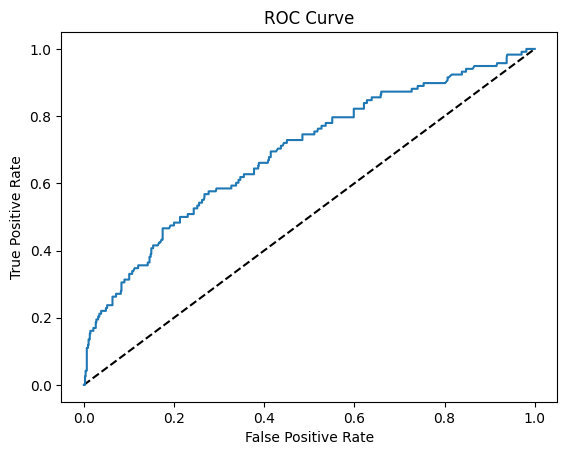

In [ ]:
# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Stacking Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# テストデータに適用する準備
S_test = np.zeros((test.shape[0], len(models)))

for i, model in enumerate(models):
    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    S_test[:, i] = model_clone.predict_proba(test)[:, 1]


In [ ]:
# メタモデルで予測
final_pred = meta_model.predict_proba(S_test)[:, 1]

In [ ]:
# 予測結果の先頭10件を表示
final_pred[:10]

array([0.01185781, 0.0992138 , 0.00965379, 0.23561181, 0.04639078,
       0.24996328, 0.03860365, 0.03729786, 0.6011116 , 0.25795263],
      dtype=float32)

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/sample_submit.csv", header=None)
# 提出ファイルの2列目を予測値で置き換えます。
submit[1] = final_pred


In [ ]:
submit.head()

,0,1
0,3489,0.011858
1,3490,0.099214
2,3491,0.009654
3,3492,0.235612
4,3493,0.046391


In [ ]:
#submission.csvでデータを保存(提出様式はindex=False, header=Noneとしてください。)
submit.to_csv("submission.csv", index=False, header=None)